In [1]:
#general imports
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

In [2]:
# Inline figures
%matplotlib inline

In [3]:
#sklearn imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [4]:
#seaborn visual style
sns.set()
sns.set_context('talk')
plt.rcParams["patch.force_edgecolor"] = False 

In [5]:
#method to calculate gfr
def gfr(seq_num, dem_data, bio_pro):
    user_dem_data = dem_data[dem_data['SEQN'] == seq_num]
    race = user_dem_data['RIDRETH1'].item()
    gender = user_dem_data['RIAGENDR'].item()
    age = user_dem_data['RIDAGEYR'].item()
    sc = bio_pro[bio_pro['SEQN'] == seq_num]['LBXSCR'].item()
    k = 0.7 if gender == 1 else 0.9
    a = -0.329 if gender == 1 else -0.411
    t = 1.159 if race == 4 else 1
    s = 1.018 if gender == 1 else 1
    return 141 * (min(sc/k, 1)**a) * (max(sc/k, 1)**-1.209) * (0.993**age) * s * t


In [6]:
#gfr helper method
def load_gfr(folder):
    bio_pro = pd.read_sas(folder + '/P_BIOPRO.XPT')
    dem_data = pd.read_sas(folder + '/P_DEMO.XPT')
    gfr_col = bio_pro['SEQN'].apply(lambda seqn: gfr(seqn, dem_data, bio_pro))
    gfr_data = pd.concat([bio_pro['SEQN'],gfr_col], axis=1, join='inner')
    gfr_data.columns = ['SEQN', 'GFR']
    #print('Number of patients with possible kidney disease: ', np.count_nonzero(gfr_col <= 60))
    return gfr_data

In [7]:
#method to build dataset
#folder is the data directory, single_cols is a dict which maps file names with a list of specific cols for that file (for example, from P_KIQ_U.XPT we only want KIQ022 so specific_cols = {'P_KIQ_U.XPT' : ['KIQ022']}
def load_and_merge(folder, specific_cols=None):
    gfr_data = load_gfr(folder)
    data_files = [gfr_data]
    for filename in os.listdir(folder):
        filepath = folder + '/' + filename
        if specific_cols and filename in specific_cols:
            #Add SEQN to cols
            col_names = ['SEQN']
            col_names.extend(specific_cols[filename])
            #Rebuild as dataframe with the correct column names (necessary for the inner join after all data files are collected)
            data_files.append(pd.DataFrame(pd.read_sas(filepath)[col_names], columns=col_names))
        else:
            data_files.append(pd.read_sas(filepath))
    return pd.concat(
        (iDF.set_index('SEQN') for iDF in data_files),
        axis=1, join='inner'
    ).reset_index()

In [8]:
#actually builds datasets
all_years = []
for year_range in ['2017-2020', '2015-2016', '2013-2014', '2011-2012', '2009-2010']:
    full_data = load_and_merge('data/' + year_range, {'KIQ_U.XPT' : ['KIQ022'], 'ALB_CR.XPT' : ['URDACT', 'URXUMA']})
    all_years.append(full_data)

In [68]:
#combine datasets into main dataset
dataset = pd.concat(all_years)

In [69]:
#potential features based on academic literature 
data = dataset[['LBXSBU', 'LBXSIR', 'LBXSTP', 'LBXTC', 'LBXSUA', 'LBXBPB', 'LBXBCD', 'LBXTHG', 'LBXBSE', 'LBXBMN', 'URXUBA', 'URXUCD', 'URXUCO', 'URXUCS', 'URXUMO', 'URXUMN', 'URXUPB', 'URXUSB', 'URXUSN', 'URXUTL', 'URXUTU', 'LBXGH', 'LBXIN', 'KIQ022', 'GFR', 'URDACT', 'URXUMA', 'URXUCR', 'RIDRETH1', 'RIAGENDR', 'RIDAGEYR', 'LBXSCR']]
delete = data[data['KIQ022'] == 9].index
data = data.drop(delete)
data['TARGET'] = data.apply(lambda row: row.GFR >= 60 and row.URDACT >= 30, axis=1)
#one hot encoding for categorical attributes
data = pd.get_dummies(data, columns=['KIQ022', 'RIDRETH1', 'RIAGENDR'], dtype='float64')
#dataset cleaning
data = data.dropna()
data = data.drop_duplicates()
data.head()

,LBXSBU,LBXSIR,LBXSTP,LBXTC,LBXSUA,LBXBPB,LBXBCD,LBXTHG,LBXBSE,LBXBMN,...,TARGET,KIQ022_1.0,KIQ022_2.0,RIDRETH1_1.0,RIDRETH1_2.0,RIDRETH1_3.0,RIDRETH1_4.0,RIDRETH1_5.0,RIAGENDR_1.0,RIAGENDR_2.0
0,17.0,71.0,6.4,168.0,5.1,1.00,0.37,0.42,195.62,16.80,...,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,34.0,108.0,7.3,161.0,6.5,1.35,0.50,0.33,219.00,8.31,...,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,16.0,102.0,6.5,161.0,4.4,1.38,0.36,0.87,212.84,8.14,...,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,12.0,83.0,7.1,146.0,6.3,2.00,0.22,1.56,203.94,6.48,...,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,11.0,68.0,7.2,187.0,5.5,1.72,1.07,0.73,174.95,7.61,...,False,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [70]:
#describe data
data.describe()

,LBXSBU,LBXSIR,LBXSTP,LBXTC,LBXSUA,LBXBPB,LBXBCD,LBXTHG,LBXBSE,LBXBMN,...,LBXSCR,KIQ022_1.0,KIQ022_2.0,RIDRETH1_1.0,RIDRETH1_2.0,RIDRETH1_3.0,RIDRETH1_4.0,RIDRETH1_5.0,RIAGENDR_1.0,RIAGENDR_2.0
count,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,...,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000
mean,13.090969,87.653796,7.128796,191.133508,5.488482,1.451695,0.524241,1.598004,196.105000,10.132971,...,0.878626,0.034031,0.965969,0.118455,0.105366,0.418194,0.201571,0.156414,0.502618,0.497382
std,5.420640,36.495748,0.468352,41.254023,1.411135,1.740817,0.592880,2.464616,25.069048,3.811359,...,0.320168,0.181369,0.181369,0.323252,0.307126,0.493424,0.401305,0.363366,0.500157,0.500157
min,2.000000,9.000000,5.300000,82.000000,2.000000,0.110000,0.070000,0.110000,120.060000,3.370000,...,0.340000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,64.000000,6.800000,162.000000,4.500000,0.710000,0.200000,0.440000,179.677500,7.550000,...,0.710000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,83.000000,7.100000,188.000000,5.400000,1.050000,0.320000,0.820000,194.070000,9.390000,...,0.840000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,15.000000,108.000000,7.400000,216.000000,6.400000,1.660000,0.630000,1.710000,209.332500,11.892500,...,0.980000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,61.000000,428.000000,9.400000,463.000000,11.100000,33.670000,7.230000,32.610000,355.990000,45.490000,...,5.470000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<AxesSubplot:xlabel='TARGET', ylabel='count'>

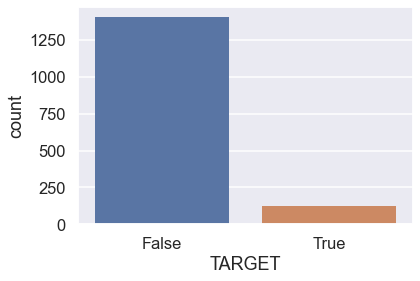

In [71]:
sns.countplot(x='TARGET', data=data)

In [72]:
#define X and y
X = data.drop(['TARGET', 'URDACT', 'GFR'], axis=1)
y = data['TARGET']

In [73]:
#Chi2 Feature Selection
select = SelectKBest(score_func=chi2, k=10)
z = select.fit_transform(X,y)
filter = select.get_support()
print(np.array(X.columns)[filter])

['LBXSIR' 'LBXTC' 'URXUBA' 'URXUMN' 'LBXGH' 'LBXIN' 'URXUMA' 'URXUCR'
 'RIDAGEYR' 'RIDRETH1_1.0']


In [74]:
#ANOVA F Feature Selection
select = SelectKBest(score_func=f_classif, k=10)
z = select.fit_transform(X,y)
filter = select.get_support()
print(np.array(X.columns)[filter])

['LBXSIR' 'LBXSTP' 'URXUMN' 'LBXGH' 'LBXIN' 'URXUMA' 'RIDAGEYR' 'LBXSCR'
 'RIDRETH1_1.0' 'RIAGENDR_2.0']


In [75]:
#Mutual Information Gain Feature Selection
select = SelectKBest(score_func=mutual_info_classif, k=10)
z = select.fit_transform(X,y)
filter = select.get_support()
print(np.array(X.columns)[filter])


['LBXSUA' 'LBXTHG' 'LBXBSE' 'URXUBA' 'LBXGH' 'URXUMA' 'LBXSCR'
 'KIQ022_2.0' 'RIDRETH1_2.0' 'RIAGENDR_2.0']


In [76]:
#Refine X to include selected features
X = X[['LBXSIR', 'LBXTC', 'URXUBA', 'URXUMN', 'LBXGH', 'LBXIN', 'URXUMA', 'URXUCR', 'RIDAGEYR', 'RIDRETH1_1.0', 'LBXSTP', 'LBXSCR', 'RIAGENDR_2.0']]
X.head()
columns = X.columns

In [77]:
#Data Normalization
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
#Test-Train Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

<AxesSubplot:xlabel='TARGET', ylabel='count'>

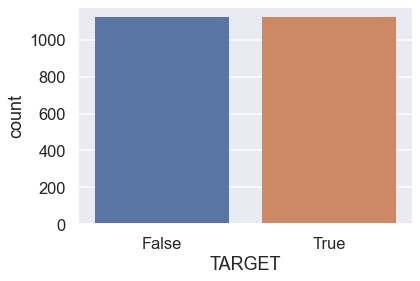

In [78]:
#SMOTE oversampling of the minority class to achieve balance
from imblearn.over_sampling import SMOTE
os = SMOTE(random_state=0)
os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['TARGET'])
X_train = os_data_X
y_train = os_data_y
sns.countplot(x='TARGET', data=y_train)

/Users/manan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/manan/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:

Mean F1: 0.987


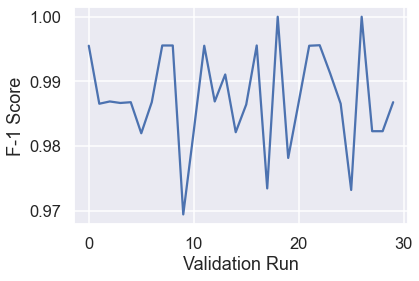

In [79]:
#Evluating through Repeated Stratified K-Fold Validation on Testing Set
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
model = RandomForestClassifier()
scores = cross_val_score(model, X_train, y_train, scoring='f1', cv=cv, n_jobs=-1)
plt.plot(list(scores))
plt.xlabel('Validation Run')
plt.ylabel('F-1 Score')
print('Mean F1: %.3f' % mean(scores))

/var/folders/hk/twqbwt0n7zb2djbmsblr0v1c0000gn/T/ipykernel_57312/3796994933.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


              precision    recall  f1-score   support

       False       0.99      1.00      0.99       279
        True       0.96      0.85      0.90        27

    accuracy                           0.98       306
   macro avg       0.97      0.92      0.95       306
weighted avg       0.98      0.98      0.98       306

[0.02784734 0.02174049 0.03202902 0.04999555 0.05660702 0.02397251
 0.54894618 0.08018321 0.03985529 0.00223608 0.03562523 0.0717161
 0.00924595]
0.9019607843137256
[[0.95 0.05]
 [0.97 0.03]
 [0.96 0.04]
 [0.99 0.01]
 [0.9  0.1 ]
 [0.14 0.86]
 [1.   0.  ]
 [1.   0.  ]
 [0.76 0.24]
 [0.76 0.24]
 [0.99 0.01]
 [0.73 0.27]
 [0.91 0.09]
 [0.97 0.03]
 [0.97 0.03]
 [0.88 0.12]
 [0.9  0.1 ]
 [1.   0.  ]
 [0.99 0.01]
 [0.54 0.46]
 [1.   0.  ]
 [0.96 0.04]
 [0.94 0.06]
 [0.97 0.03]
 [0.95 0.05]
 [0.77 0.23]
 [0.94 0.06]
 [0.23 0.77]
 [0.95 0.05]
 [0.26 0.74]
 [0.98 0.02]
 [0.98 0.02]
 [0.99 0.01]
 [0.95 0.05]
 [0.98 0.02]
 [0.9  0.1 ]
 [0.93 0.07]
 [0.86 0.14]
 [0.96 0.04]
 

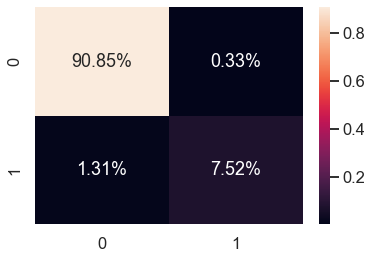

In [81]:
#Training chosen model on Training data and evaluating on Testing data
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
sns.heatmap(confusion_matrix(y_pred, y_test)/len(X_test), annot=True, fmt='.2%')
clf = classification_report(y_pred, y_test)
print(clf)
print(model.feature_importances_)
print(f1_score(y_pred, y_test))
print(model.predict_proba(X_test))